In [19]:
# Import necessary libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_lvq import GlvqModel
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score


#  Data
random.seed(42)
np.random.seed(42)

X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2️⃣ GLVQ model
model = GlvqModel(prototypes_per_class=8, random_state=42)
# Save the original _optimize method
original_optimize = model._optimize

# Create a patched version that flattens the prototypes
def patched_optimize(x, y, random_state):
    # Save the original shape of the prototypes
    original_shape = model.w_.shape
    # Flatten the prototypes for optimization
    model.w_ = model.w_.ravel()
    # Call the original optimization method (which updates model.w_ in place)
    original_optimize(x, y, random_state)
    # Reshape the optimized prototypes back to their original shape
    model.w_ = model.w_.reshape(original_shape)


model._optimize = patched_optimize

model.fit(X_train, y_train)
# Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
prototypes = model.w_




Accuracy: 0.96


In [20]:
from scipy.optimize import minimize
import numpy as np

def generate_cf_glvq_constrained(model, x_orig, y_target, C=1.0, epsilon=1e-3, bounds=None, verbose=False):
    """
    Generate counterfactual for GLVQ using proximity objective + hard margin constraint.

    Parameters:
    - model: trained GLVQ model
    - x_orig: original input sample (numpy array)
    - y_target: desired target class (int)
    - C: proximity regularization weight (float)
    - epsilon: small positive constant for numerical stability (float)
    - bounds: optional bounds for input features (list of tuples)
    - verbose: whether to print debug info

    Returns:
    - x_cf: counterfactual input (numpy array)
    - delta: change applied to original input (numpy array)
    - m_val: final margin value (float)
    """
    prototypes = model.w_
    labels = model.c_w_

    if not any(c == y_target for c in labels):
        raise ValueError(f"No prototype for target class {y_target}")

    def closest_dist(x, cls):
        dists = [np.sum((x - w) ** 2) for w, c in zip(prototypes, labels) if c == cls]
        return min(dists)

    def margin(x):
        d_plus = closest_dist(x, y_target)
        d_minus = min(np.sum((x - w) ** 2) for w, c in zip(prototypes, labels) if c != y_target)
        denom = d_plus + d_minus 
        return (d_plus - d_minus) / denom

    def loss(x):
        # Only proximity term
        prox = C * np.sum((x - x_orig) ** 2)
        return prox

    if bounds is None:
        bounds = [(-3, 3)] * len(x_orig)

    constraints = [
        {'type': 'ineq', 'fun': lambda x: -margin(x)}  # margin(x) <= 0
    ]

    result = minimize(
        loss,
        x0=x_orig,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000}
    )

    if result.success:
        x_cf = result.x
        delta = x_cf - x_orig
        m_val = margin(x_cf)
        if verbose:
            print(f"CF found. Margin: {m_val:.6f}, Δ norm: {np.linalg.norm(delta):.4f}")
        return x_cf, delta, m_val
    else:
        if verbose:
            print(f"Optimization failed: {result.message}")
        return None, None, None


In [21]:
#  verify class flip
cf_data = []
sample_indices = range(100)

for idx in sample_indices:
    x_sample = X_test[idx]
    y_orig = model.predict([x_sample])[0]
    y_target = 1 - y_orig

    x_cf, delta, m_val = generate_cf_glvq_constrained(model, x_sample, y_target, C=1.0)

    if x_cf is not None:
        y_cf = model.predict([x_cf])[0]
        if y_cf == y_target:
            print(f"CF index {idx}: class flip achieved, original pred:{y_orig}, target pred:{y_target}, Δ norm = {np.linalg.norm(delta):.4f}")
            cf_data.append((x_sample, x_cf, delta))
        else:
            print(f" CF index {idx}: class flip FAILED original pred:{y_orig}, target pred:{y_target}")
    else:
        print(f" CF index {idx}: optimization failed original pred:{y_orig}, target pred:{y_target}")

CF index 0: class flip achieved, original pred:1, target pred:0, Δ norm = 0.7832
 CF index 1: class flip FAILED original pred:0, target pred:1
 CF index 2: class flip FAILED original pred:1, target pred:0
 CF index 3: optimization failed original pred:0, target pred:1
 CF index 4: class flip FAILED original pred:1, target pred:0
 CF index 5: class flip FAILED original pred:1, target pred:0
CF index 6: class flip achieved, original pred:0, target pred:1, Δ norm = 0.6278
CF index 7: class flip achieved, original pred:0, target pred:1, Δ norm = 0.4487
 CF index 8: class flip FAILED original pred:1, target pred:0
CF index 9: class flip achieved, original pred:0, target pred:1, Δ norm = 0.3467
 CF index 10: class flip FAILED original pred:1, target pred:0
 CF index 11: class flip FAILED original pred:1, target pred:0
CF index 12: class flip achieved, original pred:0, target pred:1, Δ norm = 0.7192
CF index 13: class flip achieved, original pred:1, target pred:0, Δ norm = 0.3188
CF index 14:

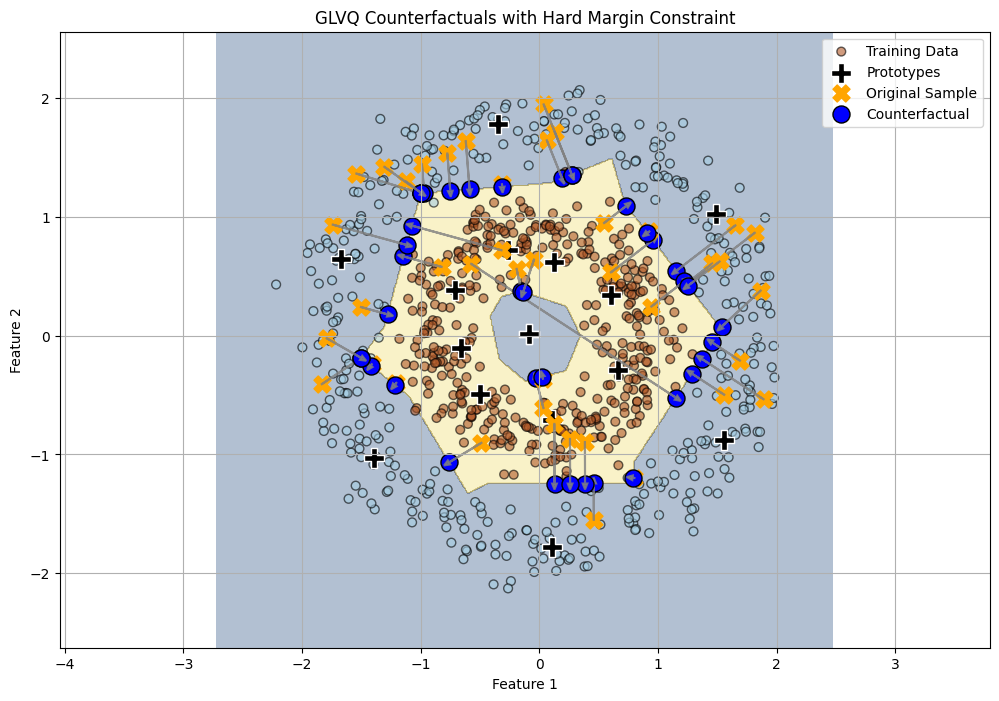

In [22]:
#  Visualization
h = 0.01
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.cividis)

plt.scatter(X_train[:, 0], X_train[:, 1],
            c=y_train, cmap=plt.cm.Paired, edgecolor='k', s=40, alpha=0.6, label='Training Data')

plt.scatter(prototypes[:, 0], prototypes[:, 1],
            marker='P', s=200, c='black', edgecolor='white', label='Prototypes')

plotted_labels = set()
for x_orig, x_cf, delta in cf_data:
    if 'Original Sample' not in plotted_labels:
        plt.scatter(*x_orig, color='orange', marker='X', s=150, label='Original Sample')
        plotted_labels.add('Original Sample')
    else:
        plt.scatter(*x_orig, color='orange', marker='X', s=150)

    if 'Counterfactual' not in plotted_labels:
        plt.scatter(*x_cf, color='blue', marker='o', edgecolor='black', s=150, label='Counterfactual')
        plotted_labels.add('Counterfactual')
    else:
        plt.scatter(*x_cf, color='blue', marker='o', edgecolor='black', s=150)

    plt.arrow(x_orig[0], x_orig[1], delta[0], delta[1],
              head_width=0.04, head_length=0.05, linewidth=1.5,
              fc='gray', ec='gray', alpha=0.8)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("GLVQ Counterfactuals with Hard Margin Constraint")
plt.grid(True)
plt.axis('equal')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()
